In [1]:
!pip install unidecode
!pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 3.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.7 MB/s eta 0:00:0000:0100:01


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import unicodedata

from unidecode import unidecode
from rapidfuzz import fuzz, process

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda  x: '%.3f' % x)
pd.set_option('display.width', 500)

In [4]:
data = pd.read_excel("/kaggle/input/talent-academy-case/Talent_Academy_Case_DT_2025.xlsx")

In [5]:
data.head()

,HastaNo,Yas,Cinsiyet,KanGrubu,Uyruk,KronikHastalik,Bolum,Alerji,Tanilar,TedaviAdi,TedaviSuresi,UygulamaYerleri,UygulamaSuresi
0,145134,60,Kadın,0 Rh+,Türkiye,"Becker Musküler Distrofisi, Hiportiroidizm, Ka...","Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi",TOZ,Ayak bileği ve ayağın yüzeysel yaralanması,Ayak Bileği,5 Seans,Ayak Bileği,20 Dakika
1,145135,28,Erkek,0 Rh+,Türkiye,"Duchenne Musküler Distrofisi, Myastenia gravis...","Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi",NaN,"Omuzun darbe sendromu,DORSALJİ, DİĞER, SERVİKO...",Dorsalji -Boyun+trapez+skapular,15 Seans,Boyun,20 Dakika
2,145135,28,Erkek,0 Rh+,Türkiye,"Duchenne Musküler Distrofisi, Myastenia gravis...","Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi",NaN,"Omuzun darbe sendromu,DORSALJİ, DİĞER, SERVİKO...",Dorsalji -Boyun+trapez+skapular,15 Seans,"Boyun,Sırt",20 Dakika
3,145135,28,Erkek,0 Rh+,Türkiye,"Duchenne Musküler Distrofisi, Myastenia gravis...","Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi",NaN,"Omuzun darbe sendromu,DORSALJİ, DİĞER, SERVİKO...",Dorsalji -Boyun+trapez+skapular,15 Seans,Boyun,5 Dakika
4,145135,28,Erkek,0 Rh+,Türkiye,"Duchenne Musküler Distrofisi, Myastenia gravis...","Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi",NaN,"Omuzun darbe sendromu,DORSALJİ, DİĞER, SERVİKO...",Dorsalji -Boyun+trapez+skapular,15 Seans,"Boyun,Sırt",20 Dakika


# Exploratory Data Analysis

In [6]:
def check_df(dataframe, head=5):
    print("############################################")
    print(dataframe.shape)
    print("############################################")
    print(dataframe.dtypes)
    print("############################################")
    print(dataframe.isnull().sum())
    print("############################################")
    print(dataframe.nunique())
    
check_df(data)

############################################
(2235, 13)
############################################
HastaNo             int64
Yas                 int64
Cinsiyet           object
KanGrubu           object
Uyruk              object
KronikHastalik     object
Bolum              object
Alerji             object
Tanilar            object
TedaviAdi          object
TedaviSuresi       object
UygulamaYerleri    object
UygulamaSuresi     object
dtype: object
############################################
HastaNo              0
Yas                  0
Cinsiyet           169
KanGrubu           675
Uyruk                0
KronikHastalik     611
Bolum               11
Alerji             944
Tanilar             75
TedaviAdi            0
TedaviSuresi         0
UygulamaYerleri    221
UygulamaSuresi       0
dtype: int64
############################################
HastaNo            404
Yas                 75
Cinsiyet             2
KanGrubu             8
Uyruk                5
KronikHastalik     220
Bolum  

In [7]:
def grab_col_names(dataframe, cat_th=10, car_th=40):
        
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == 'O']
    num_but_cat = [col for col in dataframe.columns if ((dataframe[col].dtypes != 'O') and
                                                     (dataframe[col].nunique() < cat_th))]
    cat_but_car = [col for col in dataframe.columns if ((dataframe[col].dtypes == 'O') and
                                                       (dataframe[col].nunique() > car_th))]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != 'O']
    num_cols = [col for col in num_cols if col not in num_but_cat]
    num_cols = [col for col in num_cols if col not in ["HastaNo"]]
    
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(data)

In [8]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({"Count": dataframe[col_name].value_counts(),
                       "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe[col_name])}))
    
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()
        
for col in cat_cols:
    cat_summary(data, col)

          Count  Ratio
Cinsiyet              
Kadın      1274 57.002
Erkek       792 35.436
          Count  Ratio
KanGrubu              
0 Rh+       579 25.906
A Rh+       540 24.161
B Rh+       206  9.217
AB Rh+       80  3.579
B Rh-        68  3.043
A Rh-        53  2.371
0 Rh-        26  1.163
AB Rh-        8  0.358
            Count  Ratio
Uyruk                   
Türkiye      2173 97.226
Tokelau        27  1.208
Arnavutluk     13  0.582
Azerbaycan     12  0.537
Libya          10  0.447
                                                Count  Ratio
Bolum                                                       
Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi   2045 91.499
Ortopedi Ve Travmatoloji                           88  3.937
İç Hastalıkları                                    32  1.432
Nöroloji                                           17  0.761
Kardiyoloji                                        11  0.492
Göğüs Hastalıkları                                  8  0.358
Laboratuar     

In [9]:
def num_summary(dataframe, num_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99, 1]
    print(dataframe[num_col].describe(quantiles).T)
    
    if plot:
        dataframe[num_col].hist(bins=20)
        plt.xlabel(num_col)
        plt.title(num_col)
        plt.show()

for col in num_cols:
    num_summary(data, col)

count   2235.000
mean      47.327
std       15.209
min        2.000
5%        22.000
10%       30.000
20%       37.000
30%       40.000
40%       43.000
50%       46.000
60%       49.000
70%       54.000
80%       59.000
90%       68.000
95%       74.000
99%       83.000
100%      92.000
max       92.000
Name: Yas, dtype: float64


## Missing Value Analysis

                 n_miss  ratio
Alerji              944 42.240
KanGrubu            675 30.200
KronikHastalik      611 27.340
UygulamaYerleri     221  9.890
Cinsiyet            169  7.560
Tanilar              75  3.360
Bolum                11  0.490



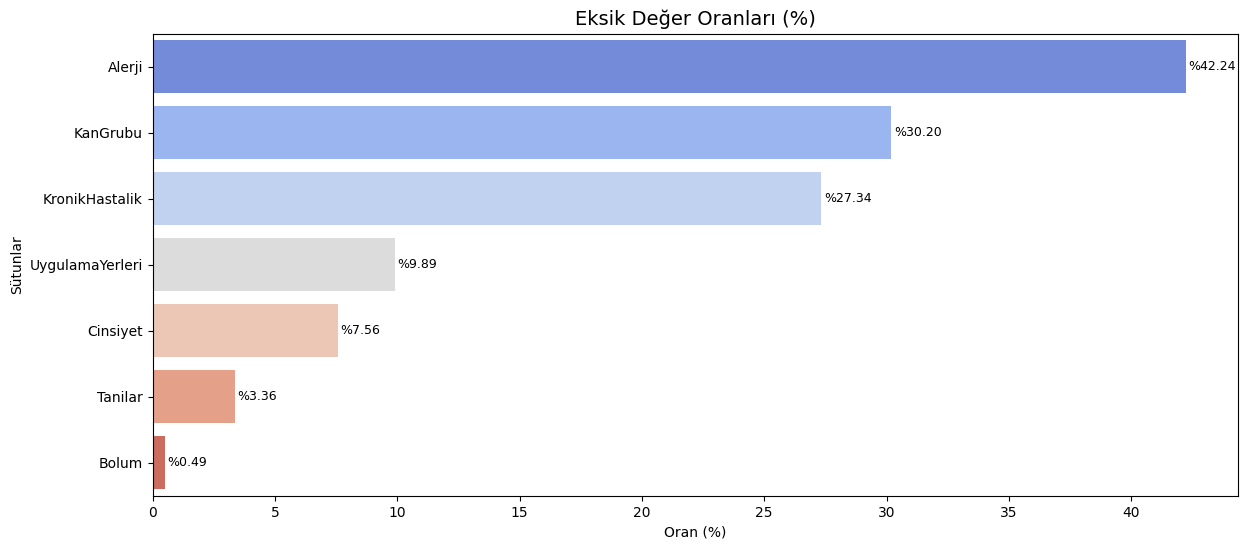

In [10]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n\n")

    if not missing_df.empty:
        plt.figure(figsize=(14, 6))
        ax = sns.barplot(x=missing_df['ratio'], y=missing_df.index, palette='coolwarm')
        plt.title("Eksik Değer Oranları (%)", fontsize=14)
        plt.xlabel("Oran (%)")
        plt.ylabel("Sütunlar")

        for i, v in enumerate(missing_df['ratio']):
            ax.text(v + 0.1, i, f"%{v:.2f}", color='black', va='center', fontsize=9)
            
        plt.show()
         
    if na_name:
        return na_columns
    
missing_values_table(data, False)

## Outlier Analysis

In [11]:
def outlier_threshold(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile = quartile3 - quartile1
    low_limit = quartile1 - 1.5 * interquantile
    up_limit = quartile3 + 1.5 * interquantile
    
    return low_limit, up_limit

In [12]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_threshold(dataframe, col_name)
    if dataframe[(dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit)].any(axis=None):
        return True
    else:
        return False
    
for col in num_cols:
    print(col, check_outlier(data, col))

Yas True


## Data Visualization

### Yaş

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


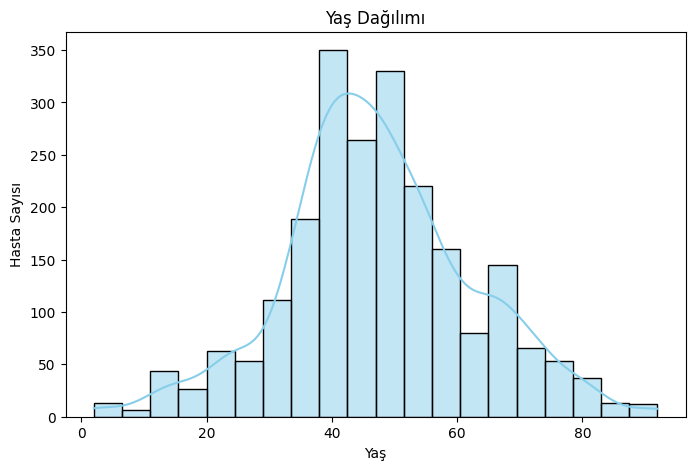

In [13]:
plt.figure(figsize=(8,5))
sns.histplot(data['Yas'], bins=20, kde=True, color='skyblue')
plt.title("Yaş Dağılımı")
plt.xlabel("Yaş")
plt.ylabel("Hasta Sayısı")
plt.show()

### Cinsiyet

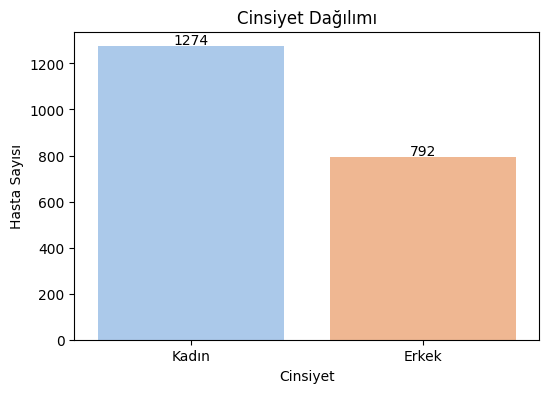

In [14]:
plt.figure(figsize=(6,4))
ax = sns.countplot(data=data, x='Cinsiyet', order=data['Cinsiyet'].value_counts().index, palette='pastel')
plt.title("Cinsiyet Dağılımı")
plt.ylabel("Hasta Sayısı")

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 10, int(height), ha='center', fontsize=10)
plt.show()

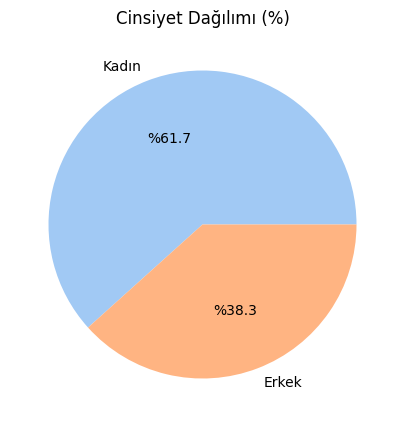

In [15]:
cinsiyet_counts = data['Cinsiyet'].value_counts()
plt.figure(figsize=(5,5))
plt.pie(cinsiyet_counts, labels=cinsiyet_counts.index, autopct=lambda p: f"%{p:.1f}", colors=sns.color_palette("pastel"))
plt.title("Cinsiyet Dağılımı (%)")
plt.show()

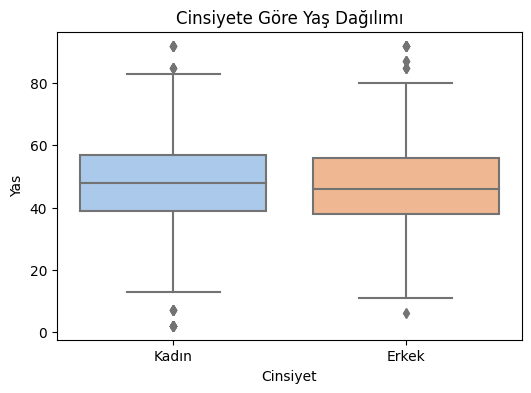

In [16]:
plt.figure(figsize=(6,4))
sns.boxplot(data=data, x='Cinsiyet', y='Yas', palette='pastel')
plt.title("Cinsiyete Göre Yaş Dağılımı")
plt.show()

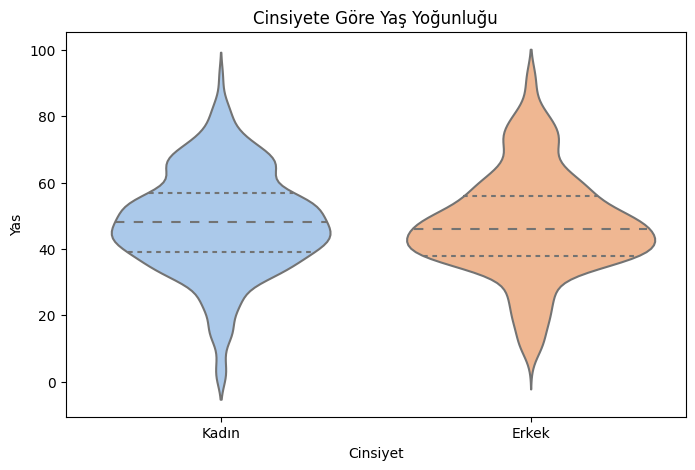

In [17]:
plt.figure(figsize=(8,5))
sns.violinplot(data=data, x='Cinsiyet', y='Yas', palette='pastel', inner='quartile')
plt.title("Cinsiyete Göre Yaş Yoğunluğu")
plt.show()

### Kan Grubu

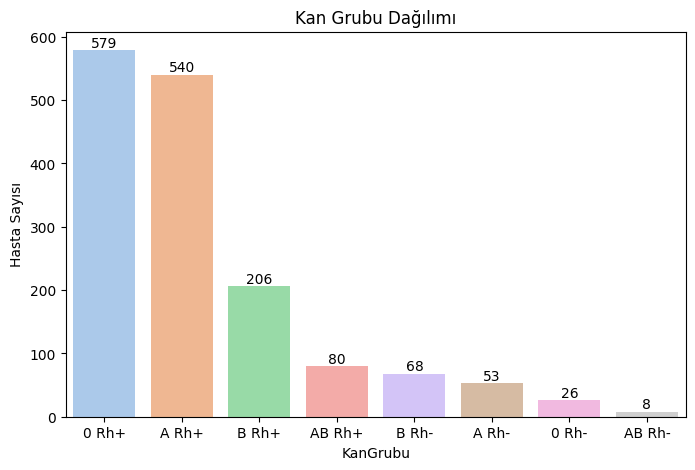

In [18]:
plt.figure(figsize=(8,5))
ax = sns.countplot(data=data, x='KanGrubu', order=data['KanGrubu'].value_counts().index, palette='pastel')
plt.title("Kan Grubu Dağılımı")
plt.ylabel("Hasta Sayısı")

# Her barın üstüne sayı yaz
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 5, int(height), ha='center', fontsize=10)

plt.show()

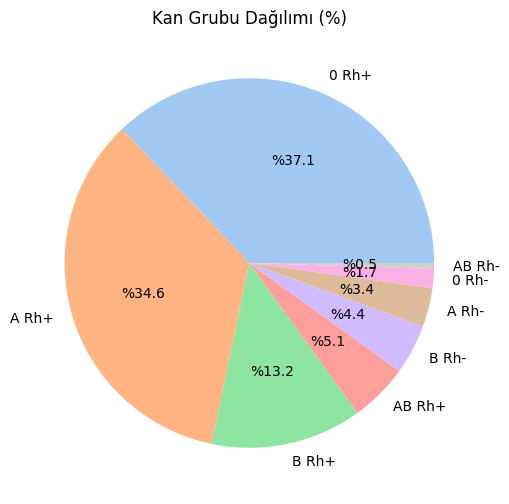

In [87]:
kan_counts = data['KanGrubu'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(kan_counts, labels=kan_counts.index, autopct=lambda p: f"%{p:.1f}", colors=sns.color_palette("pastel"))
plt.title("Kan Grubu Dağılımı (%)")
plt.show()


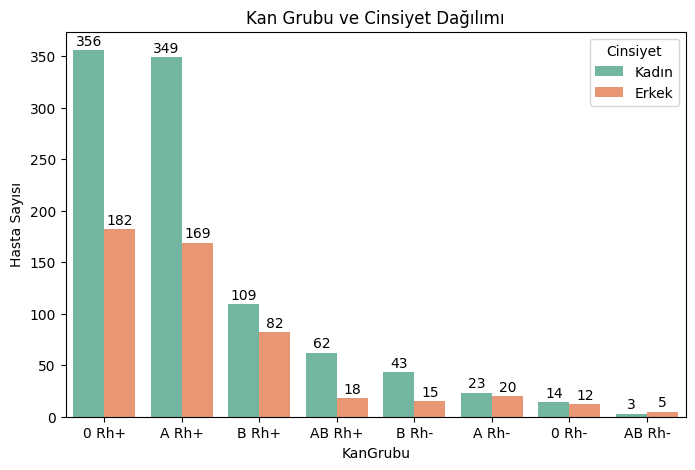

In [88]:
plt.figure(figsize=(8,5))
ax = sns.countplot(data=data, x='KanGrubu', hue='Cinsiyet', palette='Set2', order=data['KanGrubu'].value_counts().index)
plt.title("Kan Grubu ve Cinsiyet Dağılımı")
plt.ylabel("Hasta Sayısı")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 5, int(height), ha='center', fontsize=10)
plt.show()

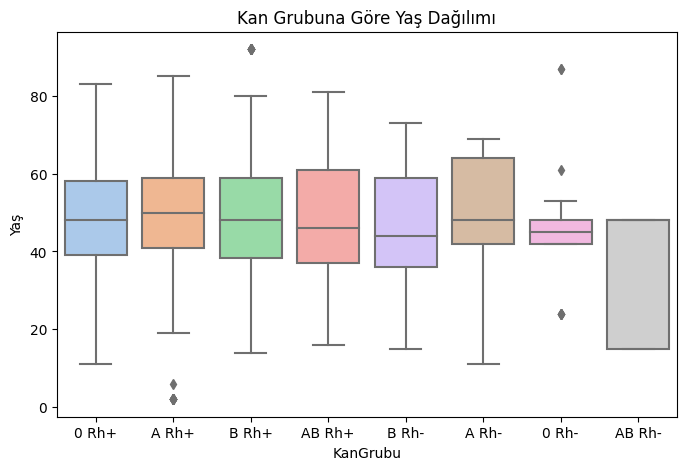

In [89]:
plt.figure(figsize=(8,5))
sns.boxplot(data=data, x='KanGrubu', y='Yas', palette='pastel', order=data['KanGrubu'].value_counts().index)
plt.title("Kan Grubuna Göre Yaş Dağılımı")
plt.ylabel("Yaş")
plt.show()

### Uyruk

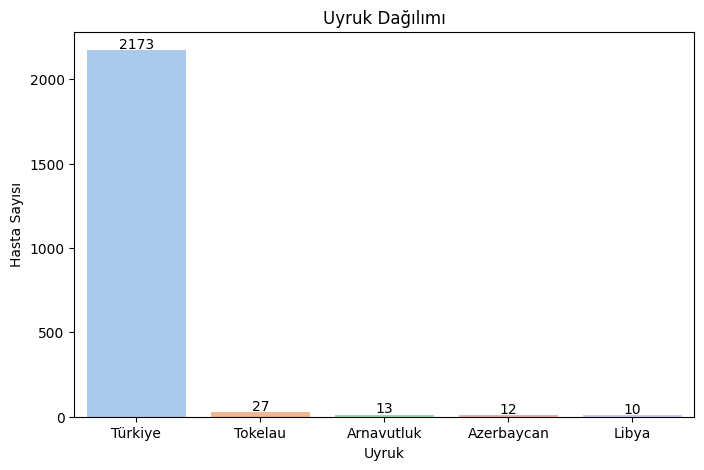

In [90]:
plt.figure(figsize=(8,5))
ax = sns.countplot(data=data, x='Uyruk', palette='pastel', order=data['Uyruk'].value_counts().index)
plt.title("Uyruk Dağılımı")
plt.ylabel("Hasta Sayısı")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 10, int(height), ha='center', fontsize=10)

plt.show()

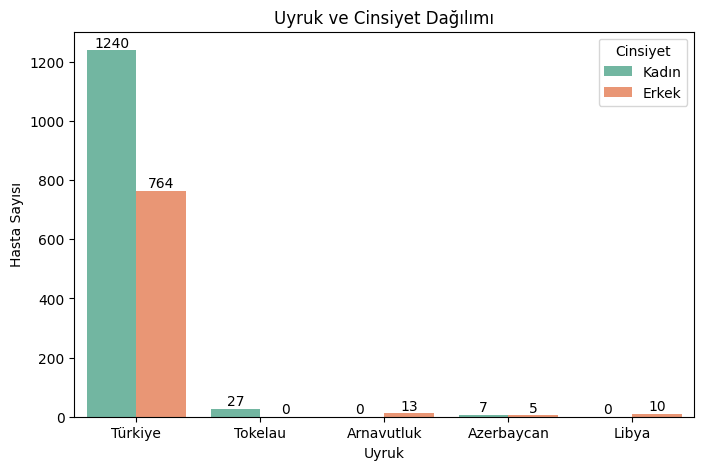

In [91]:
plt.figure(figsize=(8,5))
ax = sns.countplot(data=data, x='Uyruk', hue='Cinsiyet', palette='Set2', order=data['Uyruk'].value_counts().index)
plt.title("Uyruk ve Cinsiyet Dağılımı")
plt.ylabel("Hasta Sayısı")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 10, int(height), ha='center', fontsize=10)
plt.show()

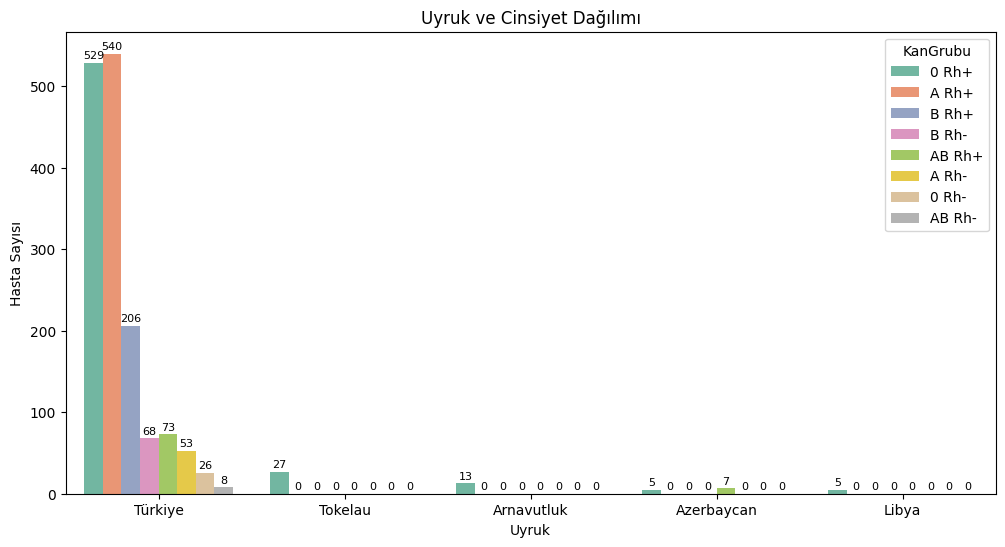

In [96]:
plt.figure(figsize=(12,6))
ax = sns.countplot(data=data, x='Uyruk', hue='KanGrubu', palette='Set2', order=data['Uyruk'].value_counts().index)
plt.title("Uyruk ve Cinsiyet Dağılımı")
plt.ylabel("Hasta Sayısı")

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 5, int(height), ha='center', fontsize=8)
plt.show()

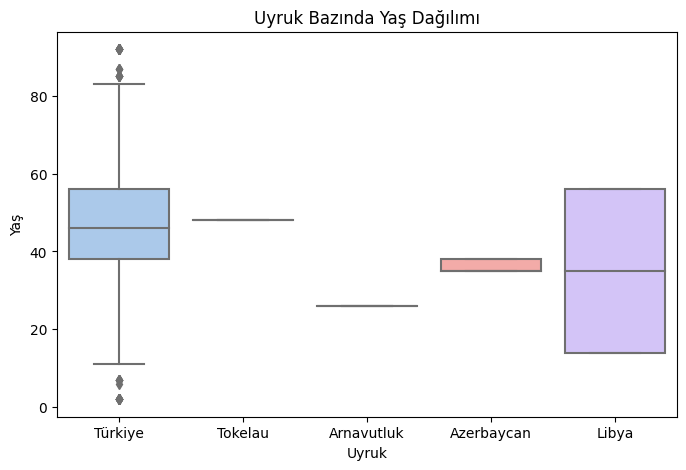

In [97]:
plt.figure(figsize=(8,5))
sns.boxplot(data=data, x='Uyruk', y='Yas', palette='pastel', order=data['Uyruk'].value_counts().index)
plt.title("Uyruk Bazında Yaş Dağılımı")
plt.ylabel("Yaş")
plt.show()

### Bölüm

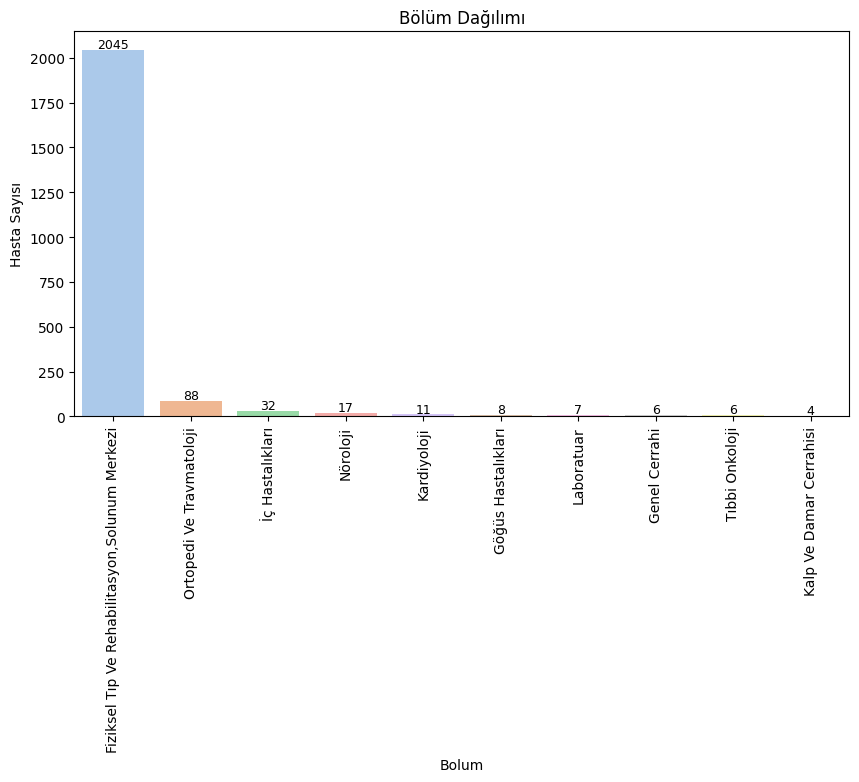

In [100]:
plt.figure(figsize=(10,5))
top_bolum = data['Bolum'].value_counts().index 
ax = sns.countplot(data=data, x='Bolum', palette='pastel', order=top_bolum)
plt.title("Bölüm Dağılımı")
plt.ylabel("Hasta Sayısı")

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 10, int(height), ha='center', fontsize=9)

plt.xticks(rotation=90)
plt.show()

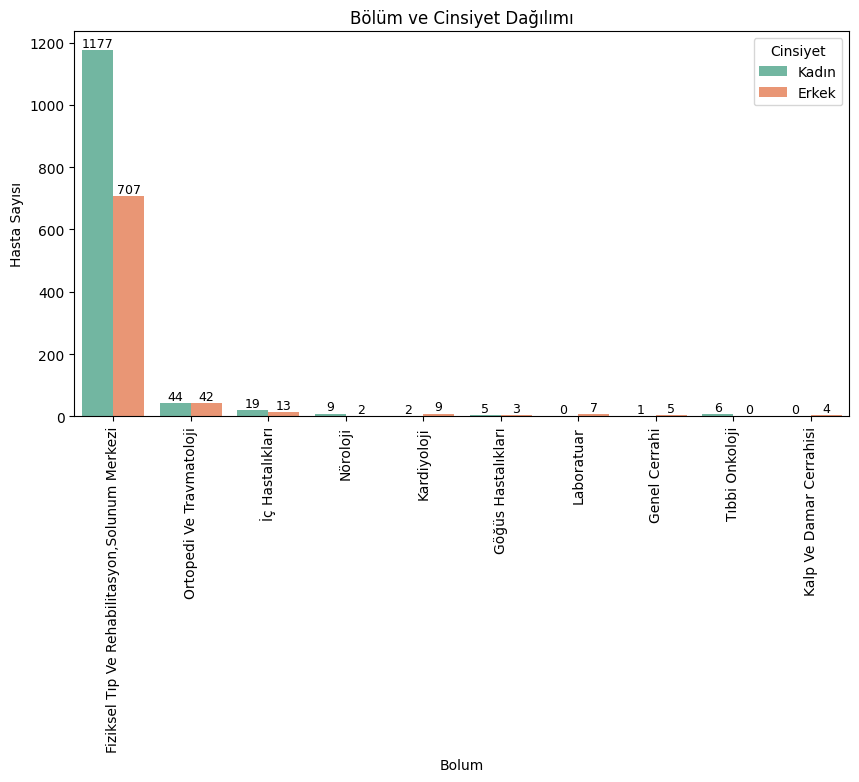

In [101]:
plt.figure(figsize=(10,5))
ax = sns.countplot(data=data, x='Bolum', hue='Cinsiyet', palette='Set2', order=top_bolum)
plt.title("Bölüm ve Cinsiyet Dağılımı")
plt.ylabel("Hasta Sayısı")
plt.xticks(rotation=90)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 10, int(height), ha='center', fontsize=9)
    
plt.show()

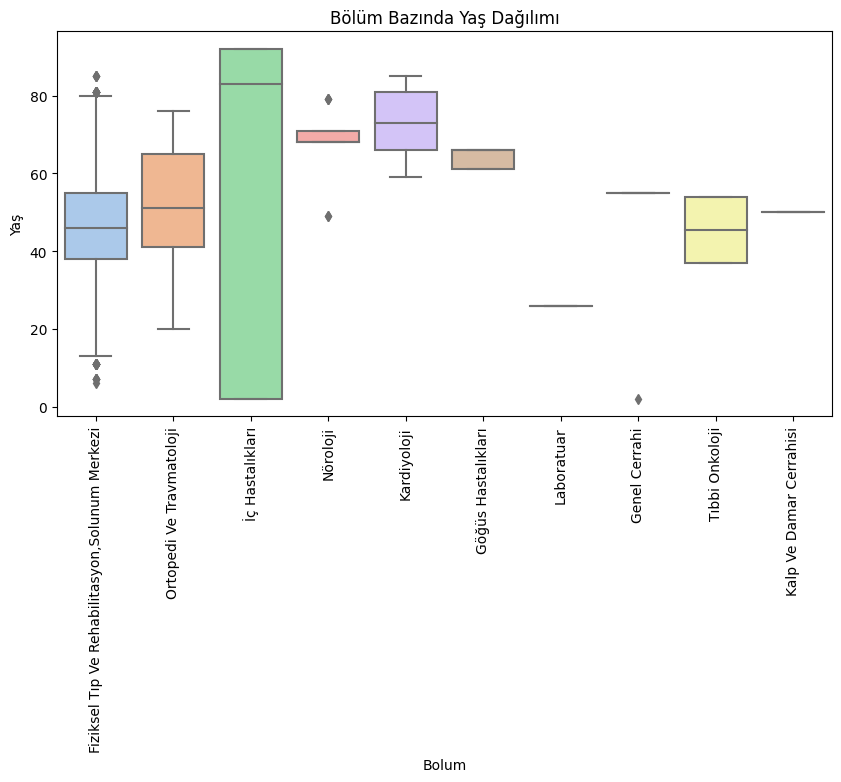

In [102]:
plt.figure(figsize=(10,5))
sns.boxplot(data=data, x='Bolum', y='Yas', palette='pastel', order=top_bolum)
plt.title("Bölüm Bazında Yaş Dağılımı")
plt.ylabel("Yaş")
plt.xticks(rotation=90)
plt.show()

### Alerji

In [103]:
Allergies = ["polen", "toz", "arveles", "coraspin", "sucuk", "novalgin", "yer fistigi", "voltaren", "gripin"]

def fuzzy_replace(text, mapping, threshold=85):
    if pd.isna(text):
        return text
    words = text.lower().split()
    new_words = []
    for w in words:
        replaced = False
        for allergi in Allergies:
            if fuzz.ratio(w.lower(), allergi) >= threshold:
                new_words.append(allergi)
                replaced = True
                break
        if not replaced:
            new_words.append(w)
    return " ".join(new_words)

data["Alerji"] = data["Alerji"].apply(lambda x: fuzzy_replace(x, Allergies))

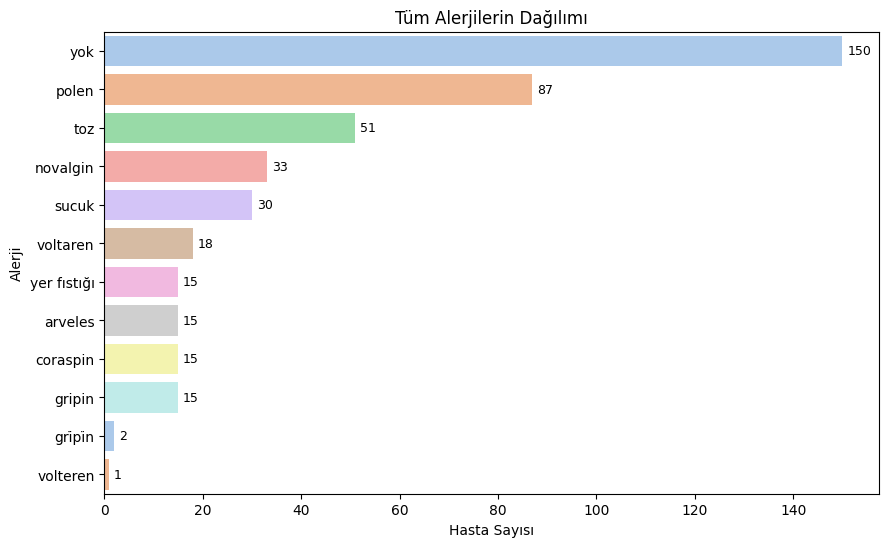

In [105]:
data_allergies = data[['HastaNo', 'Alerji', 'Cinsiyet']].copy()
data_allergies["Alerji"] = data_allergies["Alerji"].fillna("yok")

data_allergies = data_allergies.groupby(['HastaNo', 'Cinsiyet'])['Alerji'].apply(lambda x: ','.join(x)).reset_index()

data_allergies['Alerji'] = data_allergies['Alerji'].str.split(',')
data_allergies = data_allergies.explode('Alerji')
data_allergies['Alerji'] = data_allergies['Alerji'].str.strip()

data_allergies = data_allergies.drop_duplicates(subset=['HastaNo', 'Alerji'])

plt.figure(figsize=(10,6))
allergies_order = data_allergies['Alerji'].value_counts().index
ax = sns.countplot(data=data_allergies, y='Alerji', order=allergies_order, palette='pastel')
plt.title("Tüm Alerjilerin Dağılımı")
plt.xlabel("Hasta Sayısı")
plt.ylabel("Alerji")

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1, p.get_y() + p.get_height()/2., int(width), va='center', fontsize=9)

plt.show()

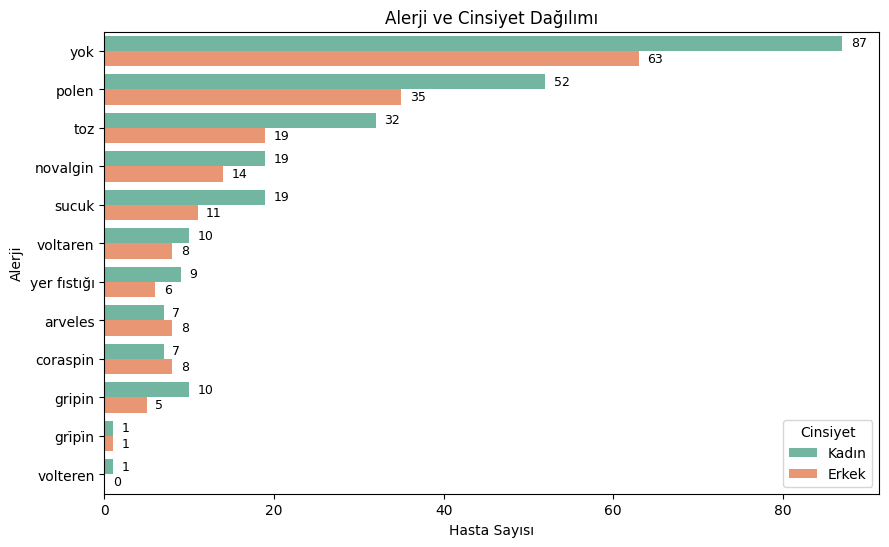

In [107]:
plt.figure(figsize=(10,6))
ax = sns.countplot(data=data_allergies, y='Alerji', hue='Cinsiyet', order=allergies_order, palette='Set2')
plt.title("Alerji ve Cinsiyet Dağılımı")
plt.xlabel("Hasta Sayısı")
plt.ylabel("Alerji")

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1, p.get_y() + p.get_height()/2., int(width), va='center', fontsize=9)
plt.show()

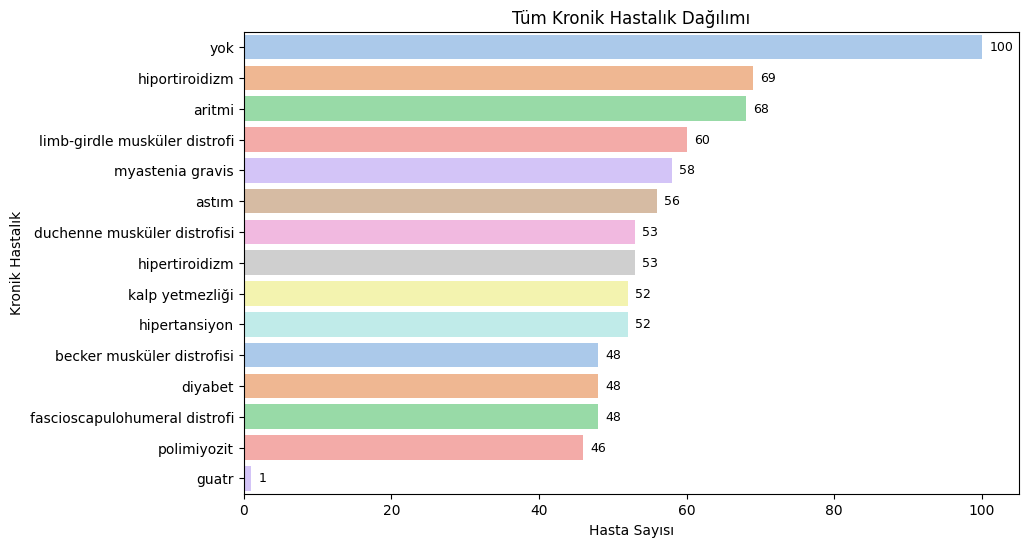

In [108]:
data_diseases = data[['HastaNo', 'KronikHastalik', 'Cinsiyet']].copy()
data_diseases["KronikHastalik"] = data_diseases["KronikHastalik"].fillna("yok")
data_diseases["KronikHastalik"] = data_diseases["KronikHastalik"].str.lower()

data_diseases = data_diseases.groupby(['HastaNo', 'Cinsiyet'])['KronikHastalik'].apply(lambda x: ','.join(x)).reset_index()

data_diseases['KronikHastalik'] = data_diseases['KronikHastalik'].str.split(',')
data_diseases = data_diseases.explode('KronikHastalik')
data_diseases['KronikHastalik'] = data_diseases['KronikHastalik'].str.strip()

data_diseases = data_diseases.drop_duplicates(subset=['HastaNo', 'KronikHastalik'])

plt.figure(figsize=(10,6))
diseases_order = data_diseases['KronikHastalik'].value_counts().index
ax = sns.countplot(data=data_diseases, y='KronikHastalik', order=diseases_order, palette='pastel')
plt.title("Tüm Kronik Hastalık Dağılımı")
plt.xlabel("Hasta Sayısı")
plt.ylabel("Kronik Hastalık")

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1, p.get_y() + p.get_height()/2., int(width), va='center', fontsize=9)

plt.show()

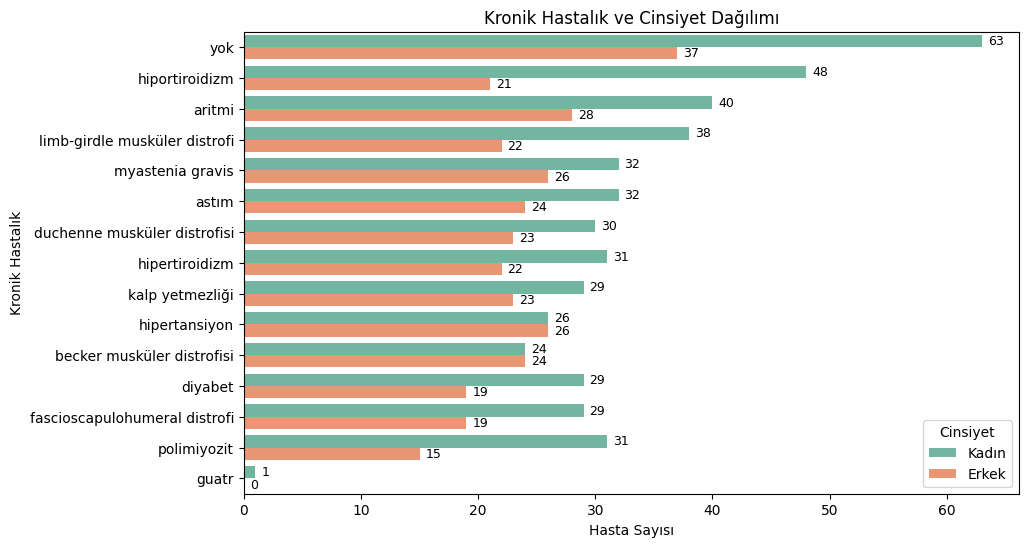

In [109]:
plt.figure(figsize=(10,6))
ax = sns.countplot(data=data_diseases, y='KronikHastalik', hue='Cinsiyet', order=diseases_order, palette='Set2')
plt.title("Kronik Hastalık ve Cinsiyet Dağılımı")
plt.xlabel("Hasta Sayısı")
plt.ylabel("Kronik Hastalık")

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.5, p.get_y() + p.get_height()/2., int(width), va='center', fontsize=9)
plt.show()

### Tanılar

In [110]:
def normalize_text(text):
    if pd.isnull(text):
        return text 
    text = unicodedata.normalize('NFKD', text)
    text = "".join([c for c in text if not unicodedata.combining(c)])
    return text.lower().strip()

In [111]:
replace_dict = {
    "diger": "diğer",
    "\u200b diger": "diger",
    "sag": "sağ",
    "sol": "sol"
}

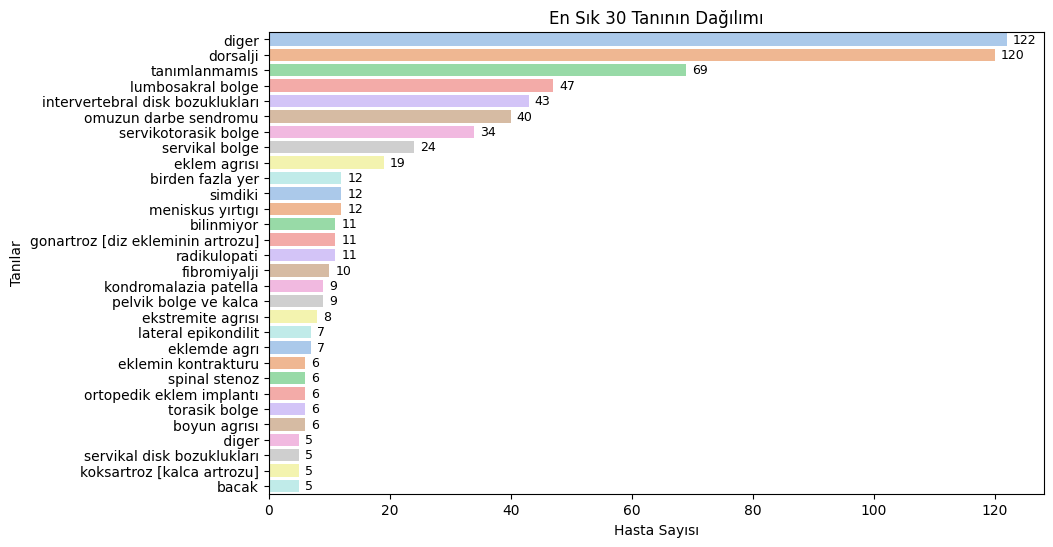

In [112]:
data_diagnoses = data[['HastaNo', 'Tanilar', 'Cinsiyet']].copy()
data_diagnoses["Tanilar"] = data_diagnoses["Tanilar"].apply(normalize_text)
data_diagnoses["Tanilar"] = data_diagnoses["Tanilar"].fillna("Bilinmiyor")
data_diagnoses["Tanilar"] = data_diagnoses["Tanilar"].str.lower()
data_diagnoses["Tanilar"] = data_diagnoses["Tanilar"].replace(replace_dict)


data_diagnoses = data_diagnoses.groupby(['HastaNo', 'Cinsiyet'])['Tanilar'].apply(lambda x: ','.join(x)).reset_index()

data_diagnoses['Tanilar'] = data_diagnoses['Tanilar'].str.split(',')
data_diagnoses = data_diagnoses.explode('Tanilar')
data_diagnoses['Tanilar'] = data_diagnoses['Tanilar'].str.strip()
data_diagnoses = data_diagnoses[data_diagnoses['Tanilar'] != ""]

data_diagnoses = data_diagnoses.drop_duplicates(subset=['HastaNo', 'Tanilar'])

plt.figure(figsize=(10,6))
top_diagnoses = data_diagnoses['Tanilar'].value_counts().nlargest(30) 
ax = sns.countplot(data=data_diagnoses[data_diagnoses['Tanilar'].isin(top_diagnoses.index)], y='Tanilar', order=top_diagnoses.index, palette='pastel')
plt.title("En Sık 30 Tanının Dağılımı")
plt.xlabel("Hasta Sayısı")
plt.ylabel("Tanılar")

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1, p.get_y() + p.get_height()/2., int(width), va='center', fontsize=9)

plt.show()

### Tedavi Süresi

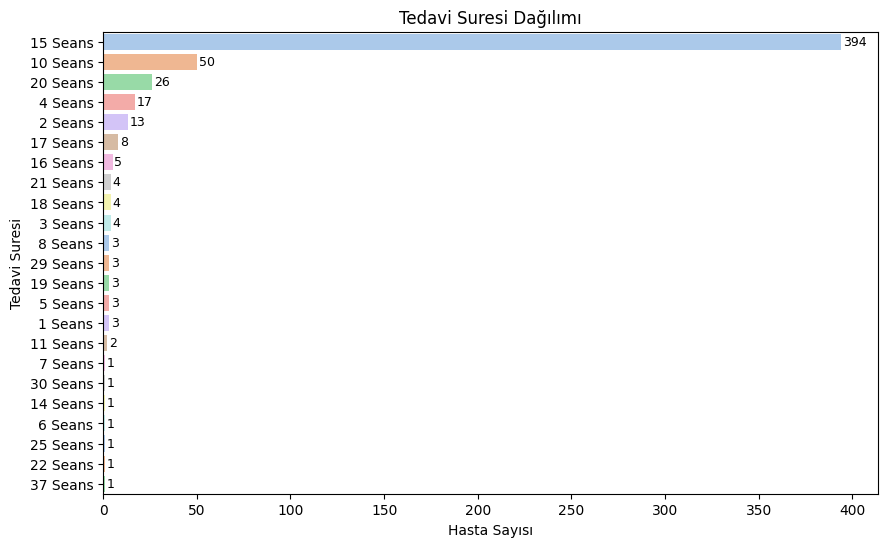

In [113]:
data_treatment_duration = data[['HastaNo', 'TedaviSuresi', 'Cinsiyet', 'Tanilar']].copy()

data_treatment_duration = data_treatment_duration.groupby(['HastaNo', 'Cinsiyet', 'Tanilar'])['TedaviSuresi'].apply(lambda x: ','.join(x)).reset_index()


data_treatment_duration['TedaviSuresi'] = data_treatment_duration['TedaviSuresi'].str.split(',')
data_treatment_duration = data_treatment_duration.explode('TedaviSuresi')
data_treatment_duration['TedaviSuresi'] = data_treatment_duration['TedaviSuresi'].str.strip()

data_treatment_duration = data_treatment_duration.drop_duplicates(subset=['HastaNo', 'TedaviSuresi', 'Tanilar'])

plt.figure(figsize=(10,6))
treatment_duration_order = data_treatment_duration['TedaviSuresi'].value_counts().index
ax = sns.countplot(data=data_treatment_duration, y='TedaviSuresi', order=treatment_duration_order, palette='pastel')
plt.title("Tedavi Suresi Dağılımı")
plt.xlabel("Hasta Sayısı")
plt.ylabel("Tedavi Suresi")

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1, p.get_y() + p.get_height()/2., int(width), va='center', fontsize=9)

plt.show()

### Uygulama Yerleri

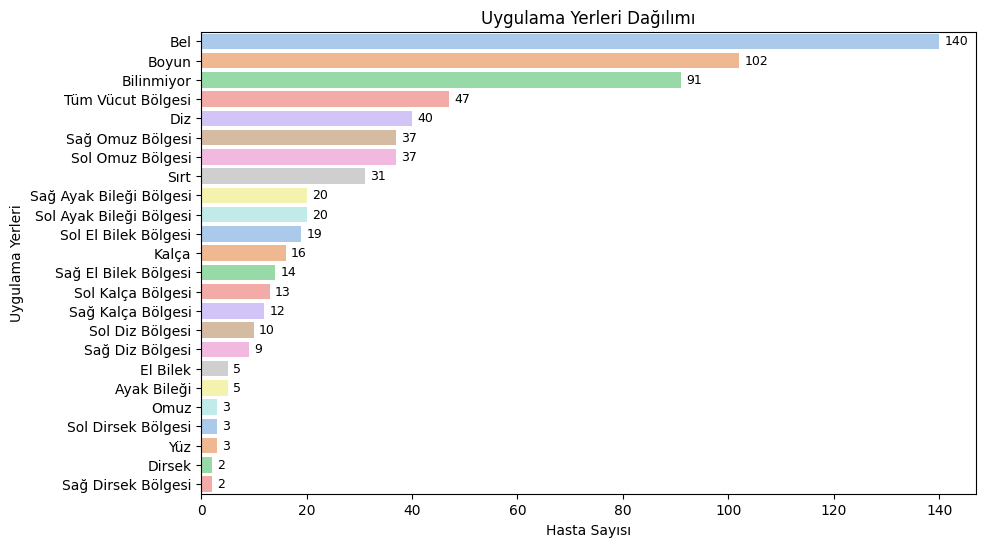

In [114]:
data_sites = data[['HastaNo', 'UygulamaYerleri', 'Cinsiyet', 'Tanilar']].copy()
data_sites["UygulamaYerleri"] = data_sites["UygulamaYerleri"].fillna("Bilinmiyor")

data_sites = data_sites.groupby(['HastaNo', 'Cinsiyet', 'Tanilar'])['UygulamaYerleri'].apply(lambda x: ','.join(x)).reset_index()


data_sites['UygulamaYerleri'] = data_sites['UygulamaYerleri'].str.split(',')
data_sites = data_sites.explode('UygulamaYerleri')
data_sites['UygulamaYerleri'] = data_sites['UygulamaYerleri'].str.strip()

data_sites = data_sites.drop_duplicates(subset=['HastaNo', 'UygulamaYerleri', 'Tanilar'])

plt.figure(figsize=(10,6))
sites_order = data_sites['UygulamaYerleri'].value_counts().index
ax = sns.countplot(data=data_sites, y='UygulamaYerleri', order=sites_order, palette='pastel')
plt.title("Uygulama Yerleri Dağılımı")
plt.xlabel("Hasta Sayısı")
plt.ylabel("Uygulama Yerleri")

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1, p.get_y() + p.get_height()/2., int(width), va='center', fontsize=9)

plt.show()